In [63]:
#基本导入
import cv2 as cv
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline


Image Shape: (400, 400)


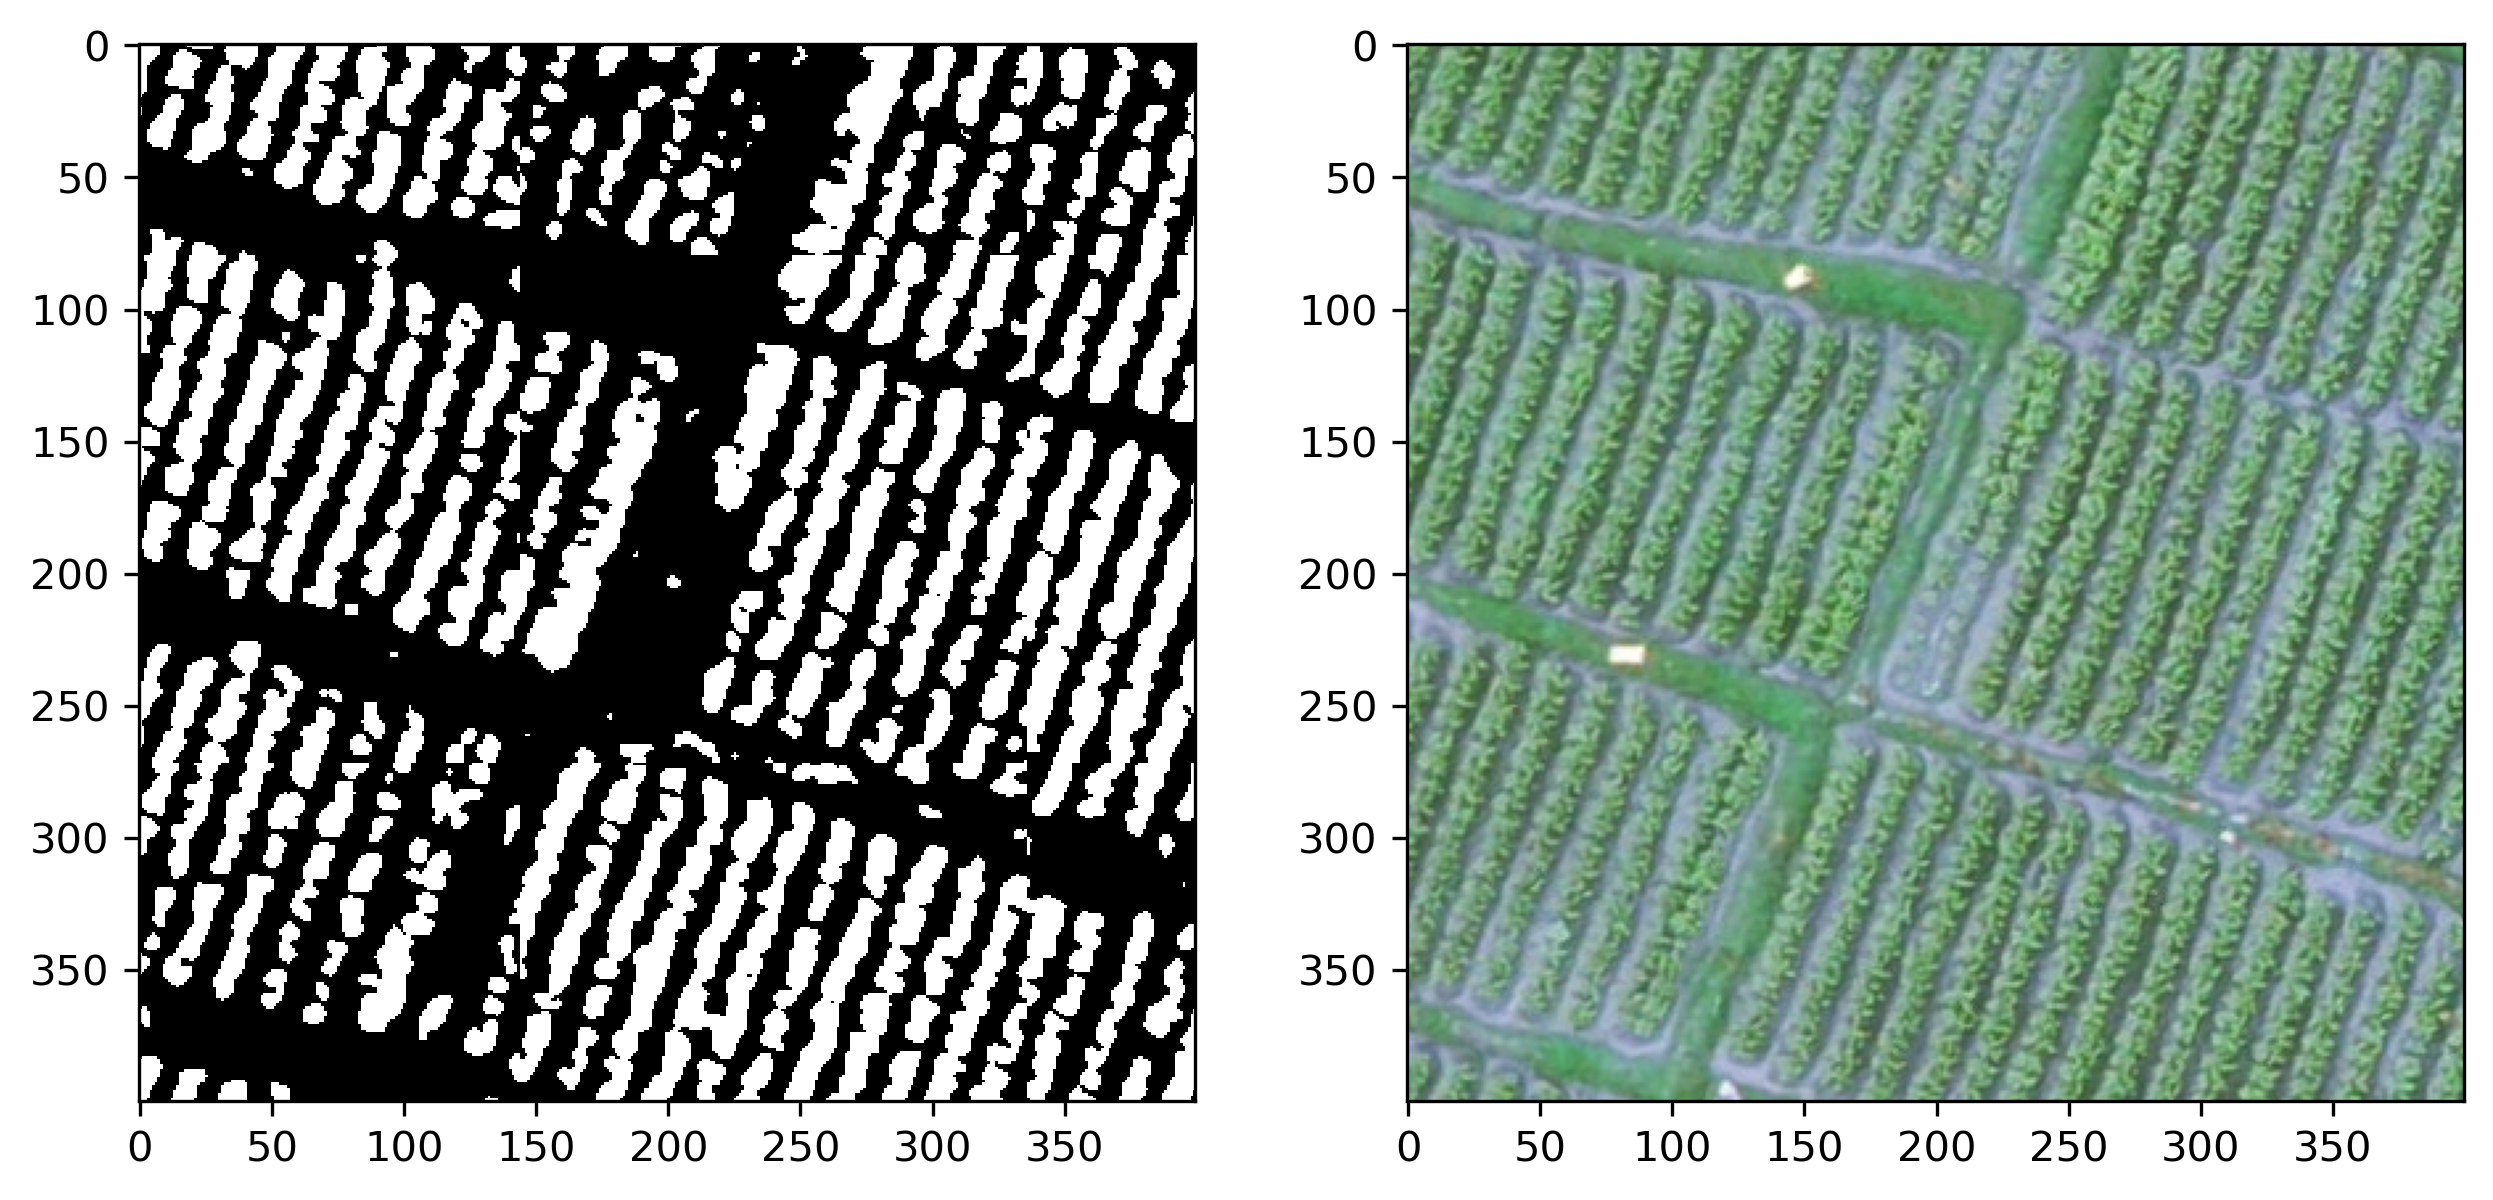

In [64]:
# Read files
path_raw = 'C:\\Users\\xianyu\\GraduationProject\\UAV_YUNNAN_DATA\\0-raw-img\\batch-1\\P061301.tif'
path_pred = 'C:\\Users\\xianyu\\GraduationProject\\UAV_YUNNAN_DATA\\3-predict_result\\P061301_result.tif'

img_pred = cv.imread(path_pred, 0)[7600:8000, 6000:6400]
img_raw = cv.imread(path_raw)[7600:8000, 6000:6400]
# Extracting the height and width of an image
print("Image Shape: {}".format(img_pred.shape))

plt.figure(figsize=(10, 5), dpi=300)
plt.subplot(121)
plt.imshow(img_pred, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(122)
plt.imshow(img_raw)

In [65]:
# 裁剪区域
roi = img_pred
h, w = roi.shape[0:2]
print(h, w)


400 400


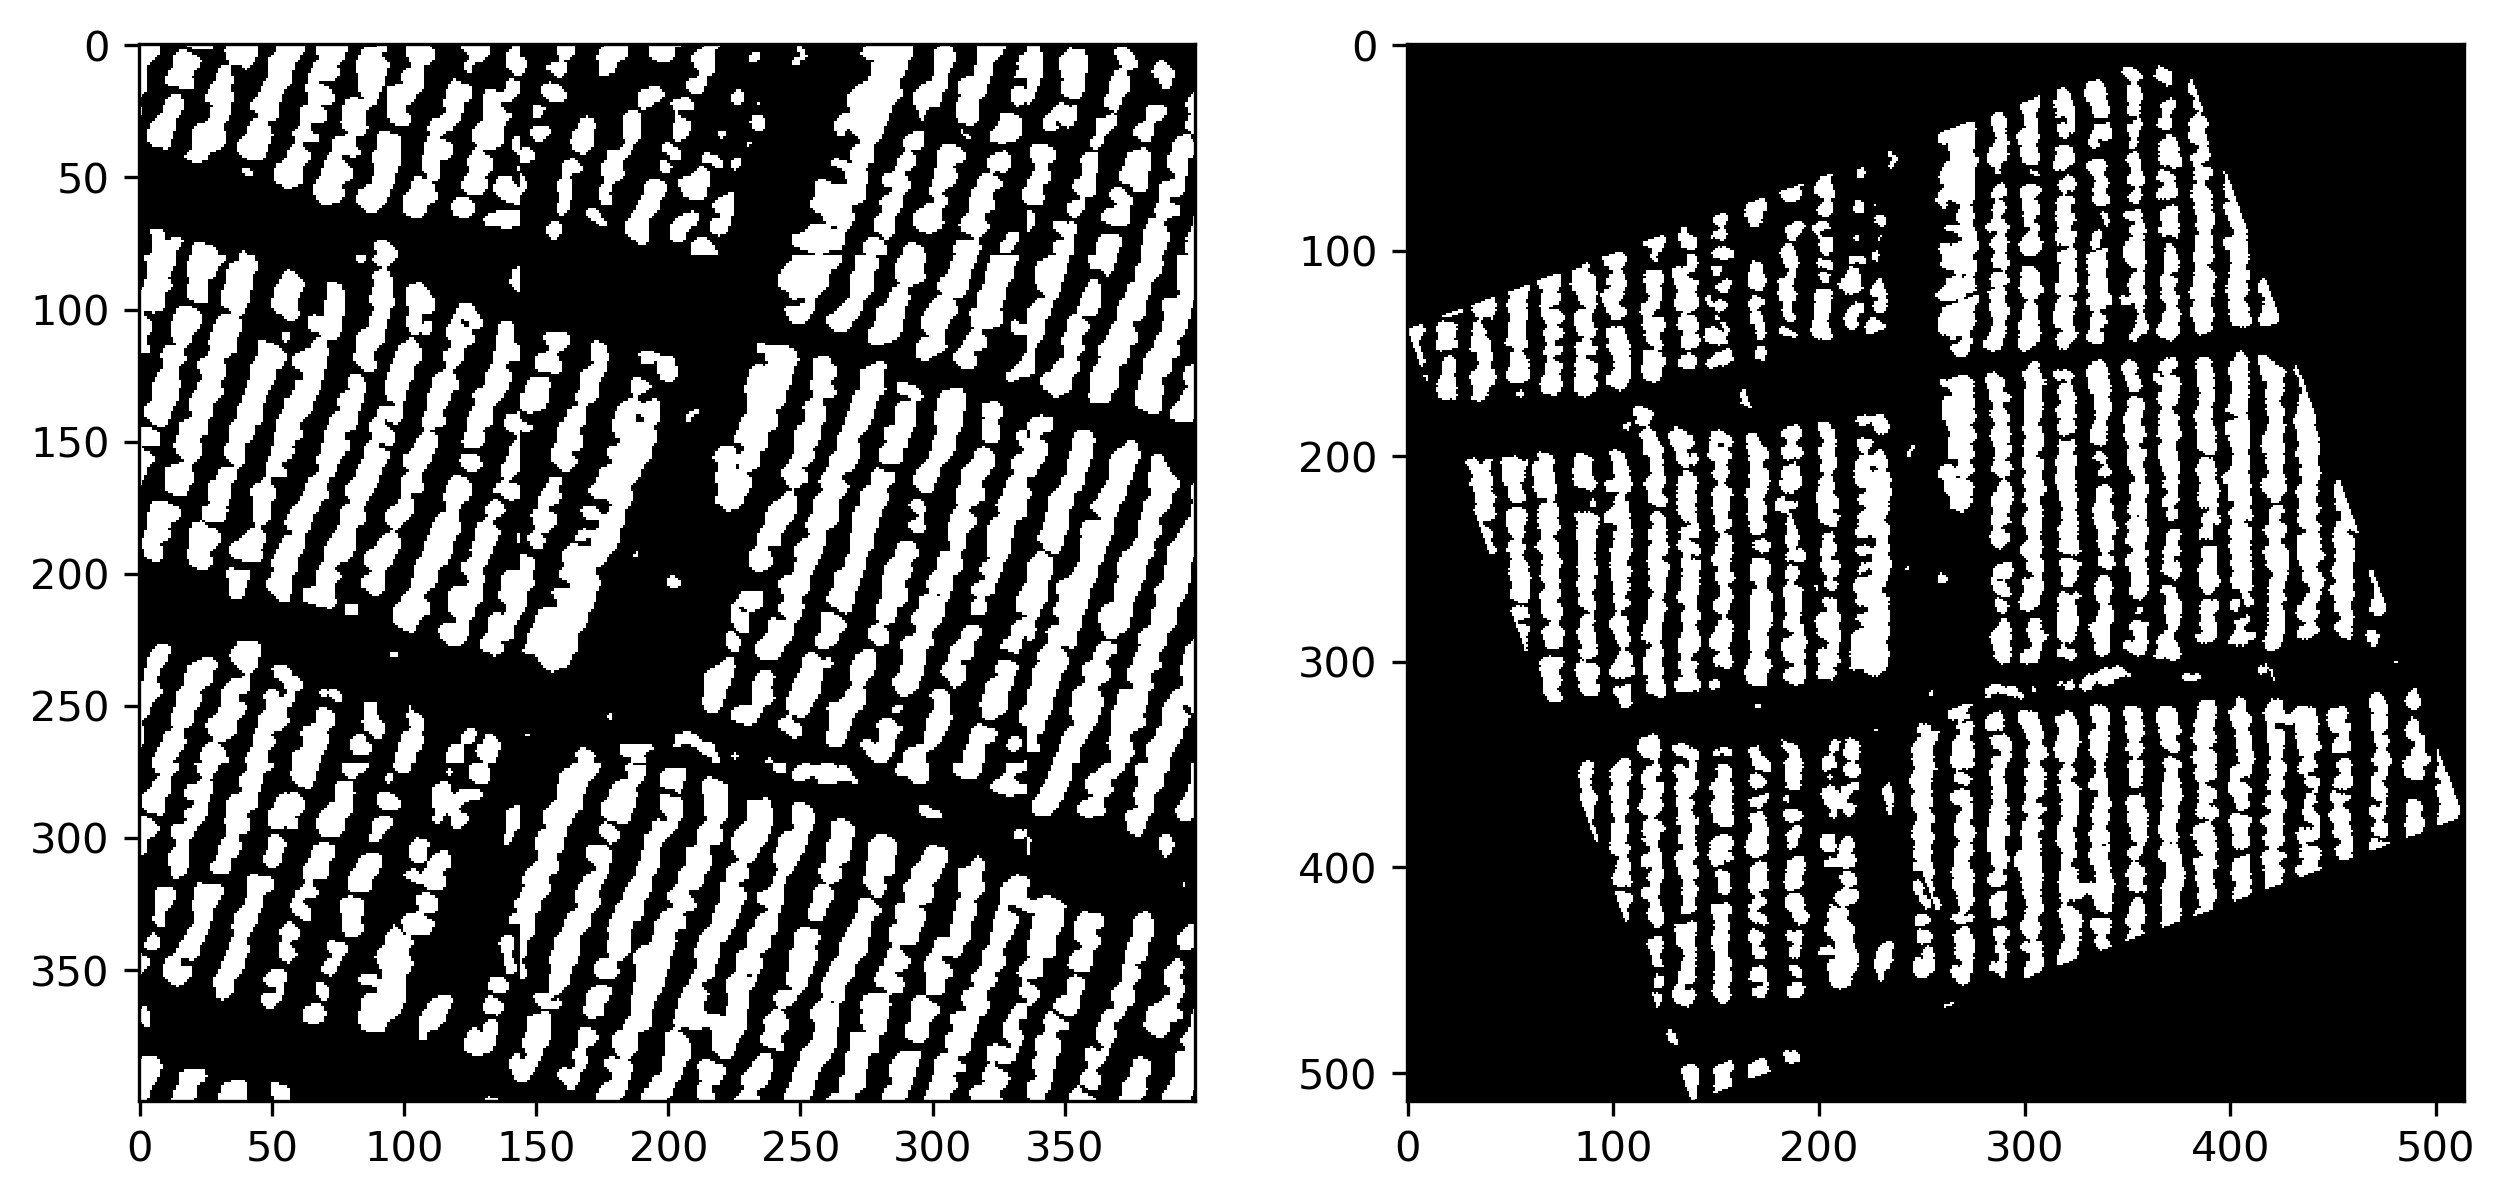

In [66]:
# 图像旋转
scale = 1  # 等比例旋转，即旋转后尺度不变
angle = 20.2  # 顺时针旋转 xx°
angle_rad = math.radians(angle)  # 弧度
padding_rate = (math.sin(angle_rad) + math.cos(angle_rad) - 1) / 2  # padding比例
padding_h, padding_w = h * padding_rate, w * padding_rate  # pad长宽的浮点数值
pad_hi, pad_wi = 1 + int(padding_h), 1 + int(padding_w)# pad长宽的整数值
center = (round(h / 2 + padding_h), round(w / 2 + padding_w))  # 以图像中心为旋转中心

roi_ = cv.copyMakeBorder(
    roi,
    pad_hi,
    pad_hi,
    pad_wi,
    pad_wi,
    cv.BORDER_CONSTANT,
)

rotate_maxtrix = cv.getRotationMatrix2D(center, angle, scale)
rotated = cv.warpAffine(roi_, rotate_maxtrix, roi_.shape, flags=cv.INTER_CUBIC)

plt.figure(figsize=(10, 5), dpi=300)
plt.subplot(121)
plt.imshow(roi, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(122)
plt.imshow(rotated, cmap='gray', vmin=0, vmax=1, interpolation='none')


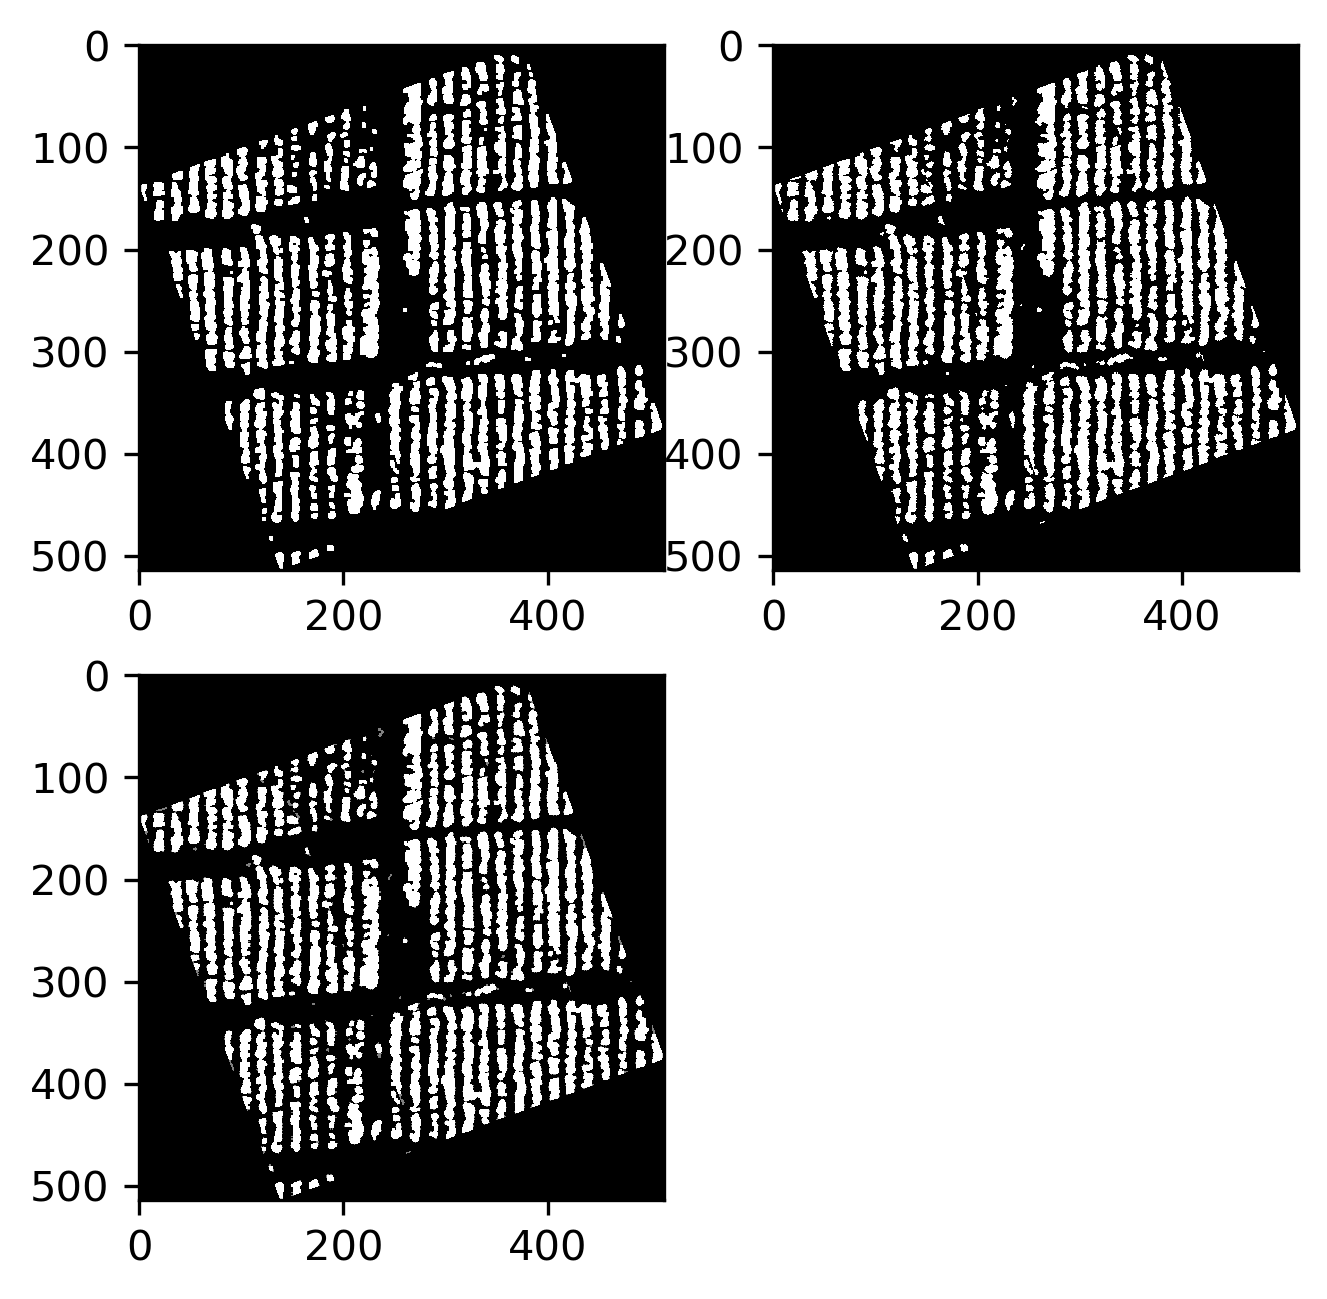

In [67]:
# 开运算
k = np.ones((3, 3), np.uint8)
open_m = cv.morphologyEx(rotated, cv.MORPH_OPEN, k)

plt.figure(figsize=(5, 5), dpi=300)
plt.subplot(221)
plt.imshow(open_m, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(222)
plt.imshow(rotated, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(223)
plt.imshow(cv.add(open_m, rotated), cmap='gray', vmin=0, vmax=2, interpolation='none')


1 1


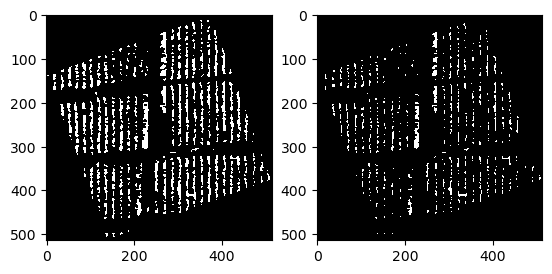

In [68]:
# 形态学 腐蚀
kernel = np.ones((1, 6), np.uint8)
erosion = cv.erode(open_m, kernel)

ero1 = cv.erode(open_m, np.ones((2, 5), np.uint8))
ero2 = cv.erode(open_m, np.ones((2, 8), np.uint8))
print(np.max(ero1), np.max(ero2))

plt.subplot(121)
plt.imshow(ero1, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(122)
plt.imshow(ero2, cmap='gray', vmin=0, vmax=1, interpolation='none')

# plt.imshow(open_m, cmap='gray', vmin=0, vmax=1, interpolation='none')

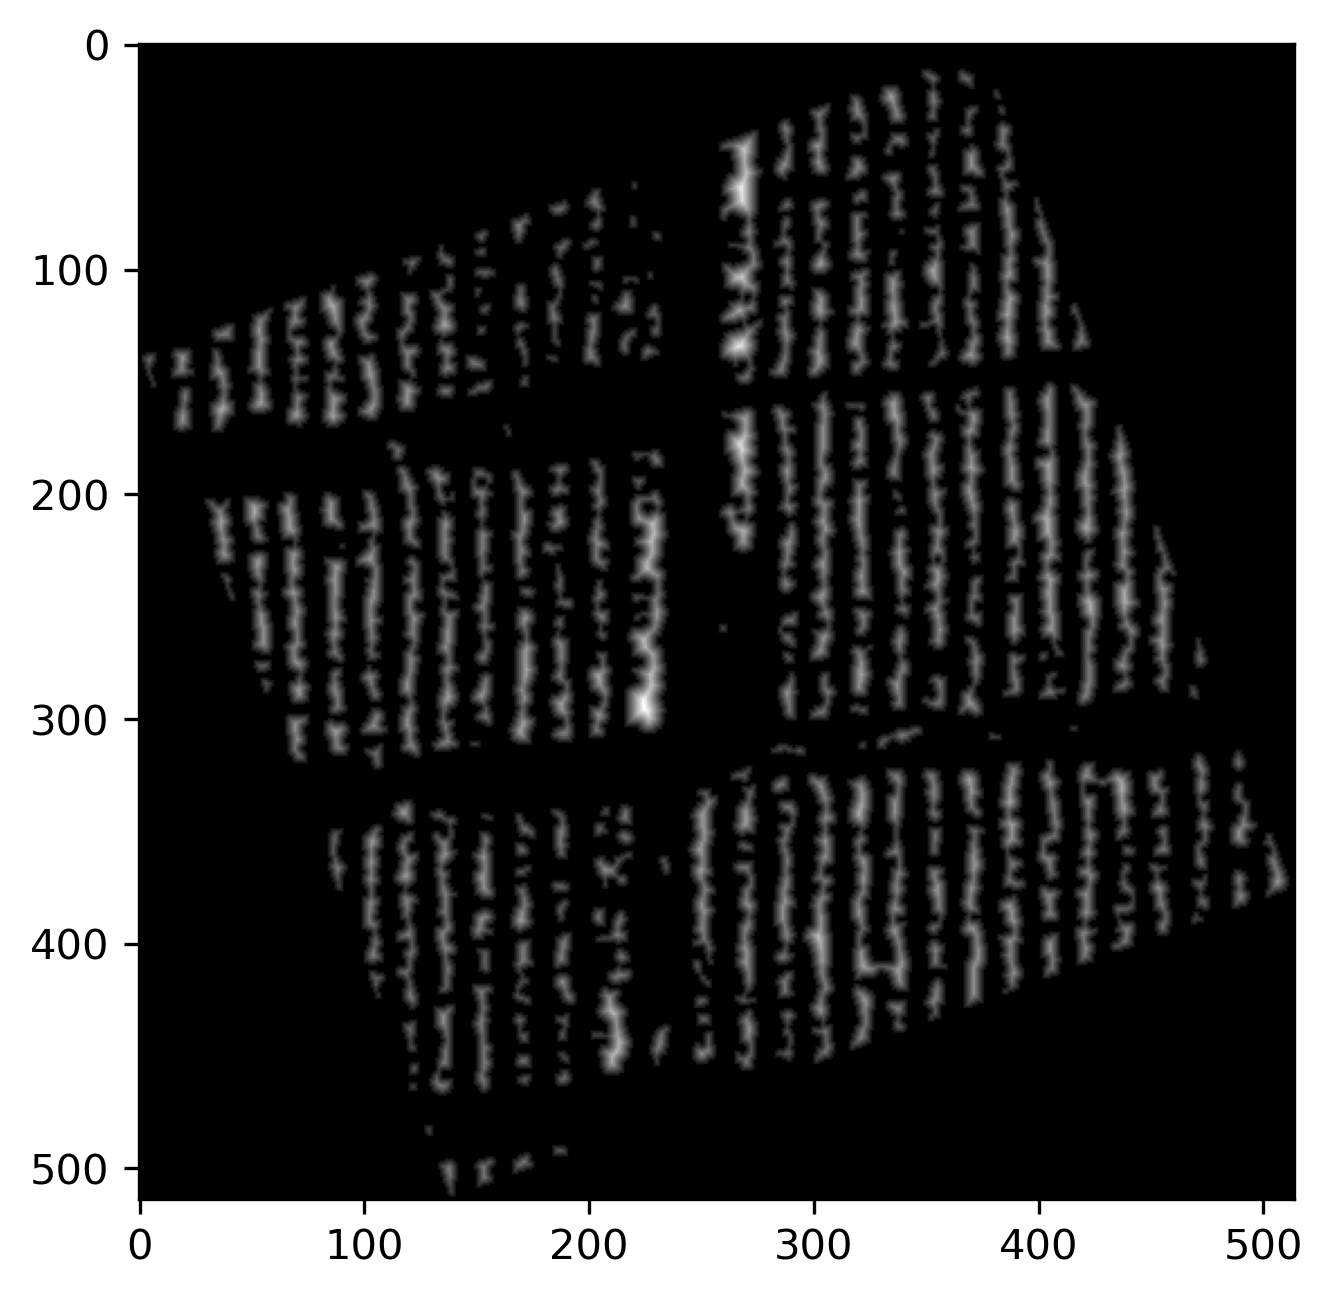

In [69]:
# 距离变换
dist_transform = cv.distanceTransform(open_m, cv.DIST_L2, 5)

ret, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 1, 0)
plt.figure(figsize=(5, 5), dpi=300)
plt.imshow(dist_transform, cmap='gray', vmin=0, vmax=dist_transform.max())

(array([21464., 18480., 10201.,  6170.,  1084.,   226.,    80.,    26.]),
 array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 8 artists>)

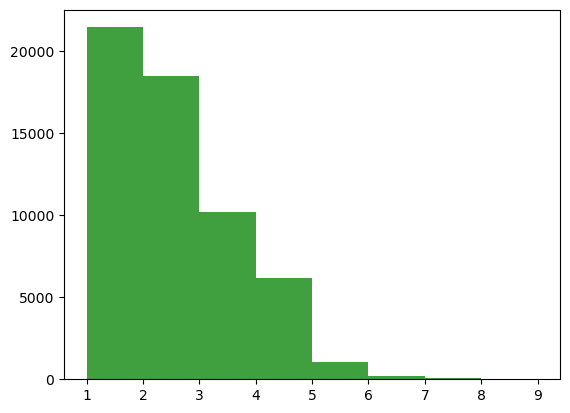

In [70]:
hist = dist_transform.reshape(-1)
plt.hist(hist, np.arange(1, 10, 1), facecolor='g', alpha=0.75)


9.0
4.5


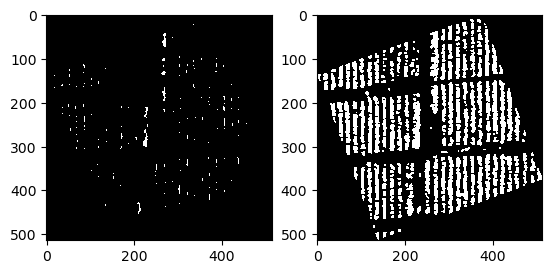

In [71]:
# 距离变换
dist_transform = cv.distanceTransform(open_m, cv.DIST_L2, 5)
print(np.max(dist_transform))
ret, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 1, 0)
print(ret)
plt.subplot(121)
plt.imshow(sure_fg, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.subplot(122)
plt.imshow(open_m, cmap='gray', vmin=0, vmax=1, interpolation='none')

In [1]:
from skimage import morphology

sk = morphology.skeletonize(ero1).astype(np.uint8)
# sk[np.where(sk > 0)] = 1
plt.imshow(cv.add(sk, ero1), cmap='gray', vmin=0, vmax=2, interpolation='none')

ModuleNotFoundError: No module named 'skimage'

In [ ]:
dst = dist_transform.astype(np.uint8)
print()
plt.imshow(dst, cmap='gray', vmin=0, vmax=np.max(dst), interpolation='none')


In [ ]:
from osgeo import gdal
import sys


def Read_img2array(img_file_path):
    """
    读取栅格数据，将其转换成对应数组
    img_file_path: 栅格数据路径
    :return: 返回投影，几何信息，和转换后的数组
    """
    dataset = gdal.Open(img_file_path)  # 读取栅格数据
    print('处理图像波段数总共有：', dataset.RasterCount)
    # 判断是否读取到数据
    if dataset is None:
        print('Unable to open *.tif')
        sys.exit(1)  # 退出
    projection = dataset.GetProjection()  # 投影
    geotrans = dataset.GetGeoTransform()  # 几何信息
    im_width = dataset.RasterXSize  #栅格矩阵的列数
    im_height = dataset.RasterYSize  #栅格矩阵的行数
    im_bands = dataset.RasterCount  #波段数
    # 直接读取dataset
    img_array = dataset.ReadAsArray()
    return im_width, im_height, im_bands, projection, geotrans, img_array


dat = Read_img2array('raw.tif')
print(dat[0:2])
print(dat[4])
